In [4]:
import numpy as np
import os
import cv2
import netCDF4
import matplotlib.pyplot as plt

In [2]:
nc_path = "E:/polar/code/data/flight9/IRdata_ATWAICE_processed_220718_142920.nc"

In [3]:
ds = netCDF4.Dataset(nc_path)
ds_size = len(ds.dimensions['t'])

imgs = ds.variables['Ts'][:]

xd = ds.variables['xd'][:]
yd = ds.variables['yd'][:]

timestamps = ds.variables['time'][:]

In [5]:
print(imgs.shape)

(4989, 480, 640)


C:\Users\marle\AppData\Local\Temp\ipykernel_13760\1461384922.py:6: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax.pcolormesh(xd[i], yd[i], imgs[i])


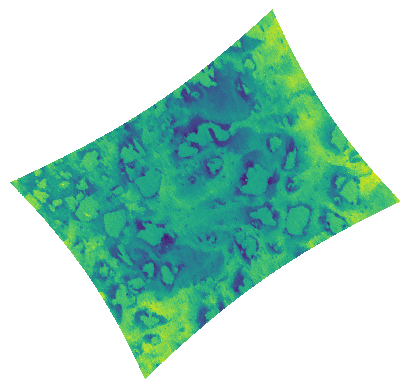

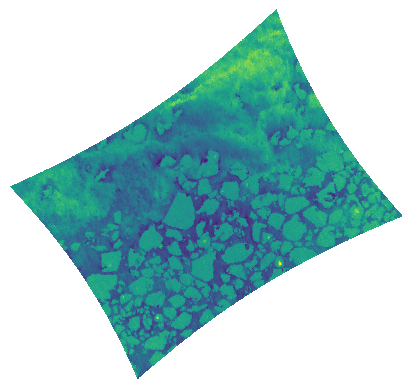

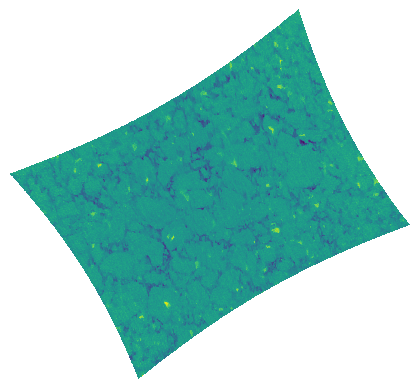

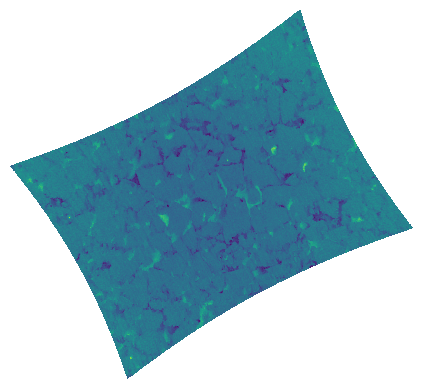

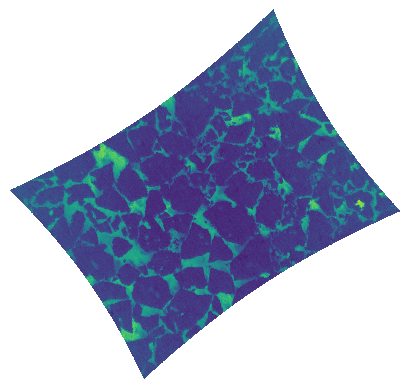

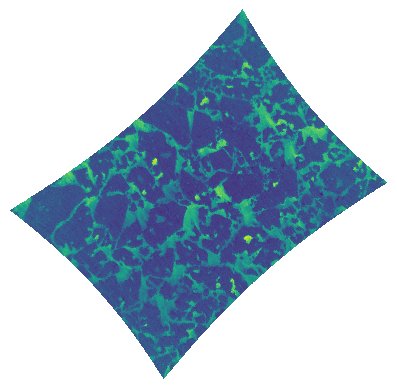

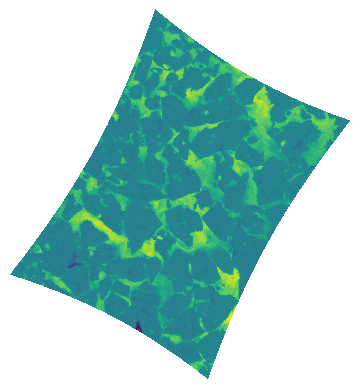

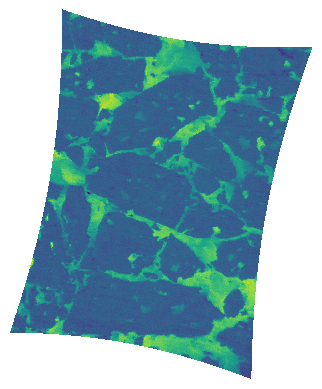

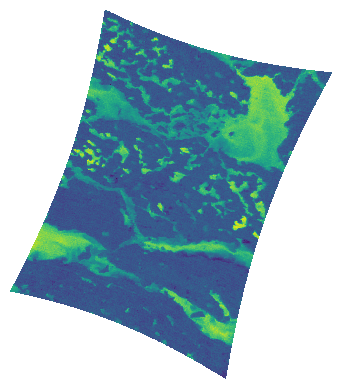

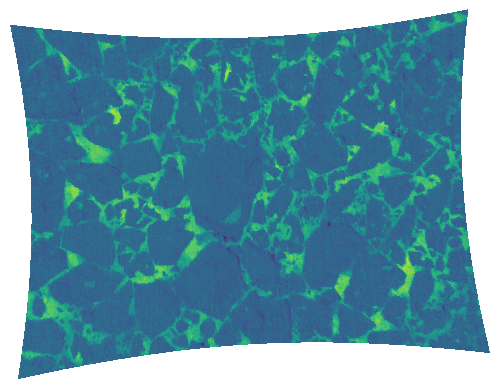

In [21]:
tests = [5, 50, 280, 300, 500, 750, 1000, 2380, 2476, 4000]
corners_list = []

for i in tests:
    fig, ax = plt.subplots()
    ax.pcolormesh(xd[i], yd[i], imgs[i])
    ax.set_aspect('equal')
    ax.axis('off')

    # corners
    x_min, x_max = np.min(xd[i]), np.max(xd[i])
    y_min, y_max = np.min(yd[i]), np.max(yd[i])

    corners = [(x_min, y_min), (x_min, y_max), (x_max, y_min), (x_max, y_max)]
    corners_list.append(corners)

    plt.savefig("./{}".format(i))

In [17]:
print(corners_list[0][0])

(10893.987, -40361.035)


In [48]:
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 100)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def calculate_angle(img):
    # convert to binary
    img[img==255] = 0
    img[img!=0] = 255
    img[img==0] = 100

    # crop to image size
    bb_full = get_bounding_box(img)
    # start_row:end_row, start_col:end_col
    crop = img[bb_full[1]:bb_full[3], bb_full[0]:bb_full[2]]

    bb_crop = get_bounding_box(crop)

    # get the corner points
    pix_up = np.where(crop[0] > 100)
    pix_do = np.where(crop[bb_crop[3]] > 100)

    start_up = np.mean(pix_up)
    start_do = np.mean(pix_do)

    pix_lef = np.where(crop[:,0] > 100)
    pix_rig = np.where(crop[:,bb_crop[2]] > 100)

    start_lef = np.mean(pix_lef)
    start_rig = np.mean(pix_rig)

    # Draw a line on the image
    start_point = (int(start_up),0)  # Define the start point of the line
    end_point = (0,int(start_lef))
    #end_point = (int(start_do),bb_crop[3])  # Define the end point of the line
    color = (0, 0, 0)
    thickness = 1  # Define the thickness of the line

    image_with_line = cv2.line(crop, start_point, end_point, color, thickness)

    #start_point = (0,int(start_lef))  # Define the start point of the line
    #end_point = (int(start_do),bb_crop[3])  # Define the end point of the line
    #color = (0, 0, 0)
    #thickness = 1  # Define the thickness of the line

    #image_with_line = cv2.line(crop, start_point, end_point, color, thickness)

    # vertical line
    image_with_line = cv2.line(crop, (0,0), (0,480), color, thickness)

        # Apply edge detection (if necessary)
    edges = cv2.Canny(image_with_line, 50, 150, apertureSize=3)

    # Apply Hough Line Transform to detect lines
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 200)

    idx = 0
    slopes = []

    # Calculate the slope of each line
    for line in lines:
        rho, theta = line[0]
        slope = -np.cos(theta) / np.sin(theta)  # Calculate the slope using the angle information
        idx = idx + 1
        slopes.append(slope)
        print(f"Slope: {slope}")

    # Display the image with the detected lines
    image_with_lines = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)  # Convert the image to color for drawing
    for line in lines:
        rho, theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        cv2.line(image_with_lines, (x1, y1), (x2, y2), (0, 0, 255), 2)  # Draw the detected lines

    plt.imshow(image_with_lines)

    """
    # Calculate the angle between the two lines
    if slopes[0] == slopes[1]:
        angle_rad = np.arctan(abs((slopes[1] - slopes[4]) / (1 + slopes[1] * slopes[4])))
    else:
        angle_rad = np.arctan(abs((slopes[0] - slopes[3]) / (1 + slopes[0] * slopes[3])))
    angle_deg = np.degrees(angle_rad)

    print(f"Angle between the two lines: {angle_deg} degrees")

    #rot = rotate(im, angle_deg)
    #cv2.imwrite("E:/test/alignment/rotated_1/{}.png".format(idx), rot)
    """

    plt.imshow(image_with_line)

C:\Users\marle\AppData\Local\Temp\ipykernel_13760\1957492400.py:67: RuntimeWarning: divide by zero encountered in float_scalars
  slope = -np.cos(theta) / np.sin(theta)  # Calculate the slope using the angle information


Slope: -inf
Slope: -inf
Slope: -inf
Slope: -inf
Slope: -inf
Slope: -inf
Slope: -inf
Slope: -inf
Slope: -inf
Slope: -0.03492076322436333
Slope: -0.03492076322436333
Slope: -inf


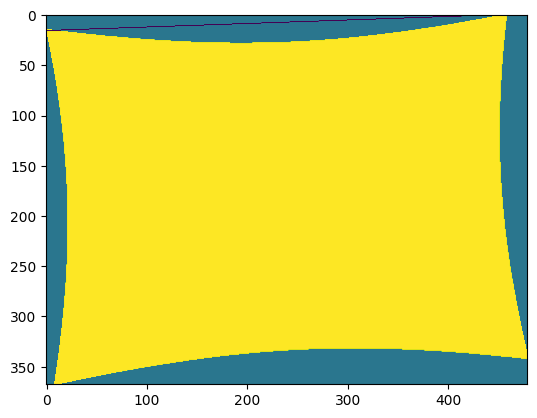

In [49]:
for i in tests:
    im = cv2.imread(os.path.join('./{}.png'.format(i)), 0)

    #corners = corners_list[i]

    calculate_angle(im)

    #color = (0, 0, 0)
    #thickness = 1

    #image_with_line = cv2.line(im, corners[0], corners[1], color, thickness)
    #image_with_line = cv2.line(im, corners[1], corners[2], color, thickness)
    #image_with_line = cv2.line(im, corners[2], corners[3], color, thickness)
    #image_with_line = cv2.line(im, corners[3], corners[4], color, thickness)

    #plt.imshow(image_with_line)
    #cv2.imwrite("./{}.png".format(i), image_with_line)    
